In [1]:
import numpy as np
import re
import plotly
plotly.tools.set_credentials_file(username='sehowerter', api_key='G5Ogb7gUjjxyuw46SW2r')
plotly.tools.set_config_file(world_readable=False,
                             sharing='private')
import plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import pandas as pd
import glob
import ternary
import datetime as dt

# Getting all ratios into one dataframe

In [2]:
allratios = pd.DataFrame(columns = ['user','tweet_id','happ_score', 'happ_words', 'likes', 'replies',
       'retweets', 'scrape_date', 'total_words', 'tweet_date','url'])
allratiofiles = glob.glob('ratios/*')
#print('All of the users we have ratios & tweet reply conversations for:')
for file in allratiofiles:
    sname = re.search('(?<=ratios/).*(?=-ratios.csv)',file).group(0)
    #print(sname)
    rdf = pd.read_csv(file)
    rdf = rdf.drop("Unnamed: 0",axis=1)
    rdf = rdf.dropna(axis=0, how='any')
    rdf['user'] = sname
    allratios = pd.concat([allratios,rdf],ignore_index=True)

for tID in list(allratios['tweet_id']):
    subset = allratios.loc[allratios['tweet_id'] == tID]
    if len(subset.index) == 2:
        hapwords = subset['happ_words']
        drop = subset.index[subset['happ_words']== min(hapwords)]
        allratios = allratios.drop(drop, axis=0)
    elif len(subset.index) > 2:
        pass
        print('dulicate tweet! ',list(subset.index))
        
    
for i in allratios.index:
    try:
        allratios.loc[i,'replies'] = float(allratios.loc[i,'replies'])
    except:
        allratios.loc[i,'replies'] = float(allratios.loc[i,'replies'][:-1])*1000
    if allratios.loc[i,'happ_words'] < 200:
        allratios.loc[i,'happ_score'] = np.nan
        
allratios['norm_replies'] = allratios['replies']/(allratios['replies'] + allratios['retweets'] + allratios['likes'])
allratios['norm_likes'] = allratios['likes']/(allratios['replies'] + allratios['retweets'] + allratios['likes'])
allratios['norm_retweets'] = allratios['retweets']/(allratios['replies'] + allratios['retweets'] + allratios['likes'])
       
        
# Subsetting to plot all tweet ratios
allhapp_ratios = allratios[['retweets','replies','likes','happ_score','user','tweet_id']]
allwords_ratios = allratios[['retweets','replies','likes','happ_words','user']]
allhapp_ratios = allhapp_ratios.T.to_dict().values()
allwords_ratios = allwords_ratios.T.to_dict().values()
'''
allratios['tweet'] = ""
tweetfiles = glob.glob('tweet_convos/{}/*'.format(screenname))
for i in allratios.index:
    file = [f for f in tweetfiles if str(allratios.loc[i,'tweet_id']) in str(f)]
    #print(file)
    for f in file:
        if 'convo-' in f:
            pass
        else:
            tweetstring = open(f,'r',encoding = 'utf-8')
            allratios.loc[i,'tweet'] = tweetstring.read()
'''
#allratios

'\nallratios[\'tweet\'] = ""\ntweetfiles = glob.glob(\'tweet_convos/{}/*\'.format(screenname))\nfor i in allratios.index:\n    file = [f for f in tweetfiles if str(allratios.loc[i,\'tweet_id\']) in str(f)]\n    #print(file)\n    for f in file:\n        if \'convo-\' in f:\n            pass\n        else:\n            tweetstring = open(f,\'r\',encoding = \'utf-8\')\n            allratios.loc[i,\'tweet\'] = tweetstring.read()\n'

## Finding the most and least happy tweet convo

In [3]:
happmin = min(list(allratios['happ_score']))
happmax = max(list(allratios['happ_score']))   
screenname_least = allratios.loc[allratios.happ_score == happmin,'user'].item()
screenname_most = allratios.loc[allratios.happ_score ==happmax,'user'].item()
tweetid_least = allratios.loc[allratios.happ_score == happmin,'tweet_id'].item()
tweetid_most = allratios.loc[allratios.happ_score ==happmax,'tweet_id'].item()

print('least happy reply thread got a score of ',happmin,' from ',screenname_least,' @ ',str(allratios.loc[allratios.happ_score == happmin,'url'].item()))
print(' w/ a ratio of: R=',str(allratios.loc[allratios.happ_score == happmin,'replies'].item()),'; RT=',str(allratios.loc[allratios.happ_score == happmin,'retweets'].item()),'; L=',str(allratios.loc[allratios.happ_score == happmin,'likes'].item()),)
print('most happy reply thread got a score of ',happmax,' from ',screenname_most,' @ ',str(allratios.loc[allratios.happ_score == happmax,'url'].item()))
print(' w/ a ratio of: R=',str(allratios.loc[allratios.happ_score == happmax,'replies'].item()),'; RT=',str(allratios.loc[allratios.happ_score == happmax,'retweets'].item()),'; L=',str(allratios.loc[allratios.happ_score == happmax,'likes'].item()),)


least happy reply thread got a score of  4.80108474577  from  SenRubioPress  @  http://twitter.com/SenRubioPress/status/887089048170500100
 w/ a ratio of: R= 391.0 ; RT= 2000 ; L= 1857
most happy reply thread got a score of  7.38128  from  SenatorBaldwin  @  http://twitter.com/SenatorBaldwin/status/804804406495608834
 w/ a ratio of: R= 101.0 ; RT= 2521 ; L= 3768


# Plotting all tweet ratios with happiness

In [4]:
rawData = list(allhapp_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['user']+'<br>happ score = '+str(round(x['happ_score'],3)), rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'cmin':happmax,
        'cmax':happmin,
        'size': 4,
        'colorbar':{'title':'Happiness Score'
                   },
        'colorscale':'YlOrRd',# Viridis Jet YlOrRd
        'showscale':True
    },
    }]
layout = {
    'title':'Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of Tweets:',
        'x': .5,
        'y': 1.19,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)

# Plotting agin to save fig at higher quality
rawData = list(allhapp_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['user']+'<br>happ score = '+str(round(x['happ_score'],3)), rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'cmin':happmax,
        'cmax':happmin,
        'size': 10,
        'colorbar':{'title':'Happiness Score',
                    'titlefont': { 'size': 30 },
                    'tickfont': { 'size': 20 },
                   },
        'colorscale':'YlOrRd',# Viridis Jet YlOrRd
        'showscale':True
    },
    }]
layout = {
    'title':'<br>Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':2000,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of All Tweets:',
        'x': .5,
        'y': 1.07,
        'font': { 'size': 44 }
    }]
}
fig = {'data': data, 'layout': layout}
py.plotly.image.save_as(fig,'Figs/ALL-ratio-happiness.jpeg')


In [5]:
ls ratios/

BBCBreaking-ratios.csv      SenJohnMcCain-ratios.csv
BarackObama-ratios.csv      SenJoniErnst-ratios.csv
BillCassidy-ratios.csv      SenKamalaHarris-ratios.csv
BillClinton-ratios.csv      SenRubioPress-ratios.csv
BillGates-ratios.csv        SenSanders-ratios.csv
ChrisCoons-ratios.csv       SenSchumer-ratios.csv
CillizzaCNN-ratios.csv      SenShelby-ratios.csv
Comey-ratios.csv            SenTedCruz-ratios.csv
Drake-ratios.csv            SenThadCochran-ratios.csv
EPAScottPruitt-ratios.csv   SenWarren-ratios.csv
FoxNews-ratios.csv          SenateGOP-ratios.csv
HillaryClinton-ratios.csv   SenateMajLdr-ratios.csv
InhofePress-ratios.csv      SenatorBaldwin-ratios.csv
JackKingston-ratios.csv     SenatorLeahy-ratios.csv
JerryMoran-ratios.csv       SenatorRounds-ratios.csv
JohnBoozman-ratios.csv      SenatorTester-ratios.csv
KatyTurNBC-ratios.csv       SenatorTomUdall-ratios.csv
KellyannePolls-ratios.csv   SenatorWicker-ratios.csv
KingJames-ratios.csv        SethAbramovitch-ratios.csv
LilTunech

# Comparing mulitple user's ratios (average ratio plot)

In [84]:
POTUSes = ['BarackObama','BillClinton','realDonaldTrump','GeorgeHWBush','GeorgeWBush__','POTUS']
#FLOTUSes = ['HillaryClinton','laurawbush','MichelleObama','MELANIATRUMP','FLOTUS']
otherpoliticalfigs = ['EPAScottPruitt','Comey','KellyannePolls','xychelsea','whca','VP','SenateGOP','HillaryClinton','laurawbush','MichelleObama','MELANIATRUMP','FLOTUS']
media_pundits = ['CillizzaCNN','KatyTurNBC','marcorubio','hughhewitt','SethAbramovitch','JackKingston','jimmyfallon','TheEllenShow','StephenAtHome']
#media = ['jimmyfallon','TheEllenShow','StephenAtHome']
news = ['BBCBreaking','FoxNews','cnnbrk']
celebs = ['Drake','KingJames','LilTunechi','kanyewest','iamcardib','MileyCyrus','taylorswift13','ladygaga','katyperry','chrissyteigen','ShaniaTwain','TheTweetOfGod','BillGates']
#rappers = ['Drake','KingJames','LilTunechi','kanyewest','iamcardib']

# Adding the senators non-scraped tweet ratios for a better computation of their average
# #hugedataset #beware
senators = pd.read_csv('senators.csv',encoding='latin-1')
senators['likes'] = senators['favorites']
senators['norm_replies'] = senators['replies']/(senators['replies']+senators['retweets']+senators['likes'])
senators['norm_retweets'] = senators['retweets']/(senators['replies']+senators['retweets']+senators['likes'])
senators['norm_likes'] = senators['likes']/(senators['replies']+senators['retweets']+senators['likes'])
senators['tweet_id'] = [re.search('(?<=status/).*',senators.loc[i,'url']).group(0) for i in senators.index]
senators['group']= ['senators_'+str(senators.loc[i,'party']) for i in senators.index]
senators_D = list(set(senators.loc[senators.group=='senators_D','user']))
senators_R = list(set(senators.loc[senators.group=='senators_R','user']))
senators_R.append('SenateMajLdr')
senators_I = list(set(senators.loc[senators.group=='senators_I','user']))
senators['tweet_date'] = [str('20'+re.search('(?<=\/)..(?= )',senators.loc[i,'created_at']).group(0)+'-'+
                            "%02d"%int(re.search('^.{1,2}(?=\/)',senators.loc[i,'created_at']).group(0))+'-'+
                            "%02d"%int(re.search('(?<=\/).{1,2}(?=\/)',senators.loc[i,'created_at']).group(0)))
                         for i in senators.index]
senators['tweet'] = senators['text']
senators = senators.drop(labels=['favorites','text','created_at','bioguide_id','party','state'],axis=1) 
senators['happ_score'] = np.nan
senators['happ_words'] = np.nan
senators['total_words'] = np.nan
senators['scrape_date'] = np.nan
allratios['group'] = np.nan
senators.set_index('tweet_id')
allratios.set_index('tweet_id')
senators = senators.drop([i for i in allratios.index if i in senators.index])

allratios = pd.concat([allratios,senators])
groups = [POTUSes,FLOTUSes,otherpoliticalfigs,pundits,media,news,celebs,rappers,senators_D,senators_R,senators_I]
group_names = ['POTUSes','FLOTUSes','otherpoliticalfigs','pundits','media','news','celebs','rappers','senators_D','senators_R','senators_I']
for i,g in enumerate(groups):
    groupdf = allratios.loc[[i for i in allratios.index if allratios.loc[i,'user'] in g],:]
    groupdf['group'] = group_names[i]
    allratios.update(groupdf)

allratios

,group,happ_score,happ_words,likes,norm_likes,norm_replies,norm_retweets,replies,retweets,scrape_date,total_words,tweet,tweet_date,tweet_id,url,user
0,celebs,5.566133,450,3137,0.729874,0.0318753,0.23825,137,1024,2018-04-30_19_40_39,1626,NaN,2018-04-23,988480166765641728,http://twitter.com/BillGates/status/9884801667...,BillGates
1,celebs,5.772030,596,3372,0.730661,0.0374865,0.231853,173,1070,2018-04-30_19_39_09,2046,NaN,2018-04-23,988502266129797129,http://twitter.com/BillGates/status/9885022661...,BillGates
2,celebs,5.635230,608,12405,0.691048,0.0244555,0.284497,439,5107,2018-04-30_19_37_45,2272,NaN,2018-04-24,988748643959279616,http://twitter.com/BillGates/status/9887486439...,BillGates
3,celebs,5.981941,711,2832,0.790841,0.0726054,0.136554,260,489,2018-04-30_19_36_17,2294,NaN,2018-04-24,988984613639831552,http://twitter.com/BillGates/status/9889846136...,BillGates
4,celebs,5.974891,640,5997,0.814699,0.0404836,0.144817,298,1066,2018-04-30_19_34_58,2096,NaN,2018-04-25,989108518031683586,http://twitter.com/BillGates/status/9891085180...,BillGates
5,celebs,5.805595,992,10274,0.780166,0.026046,0.193788,343,2552,2018-04-30_19_33_28,3518,NaN,2018-04-26,989474173759250433,http://twitter.com/BillGates/status/9894741737...,BillGates
6,celebs,6.109281,473,3356,0.873276,0.0439761,0.0827479,169,318,2018-04-30_19_32_06,1610,NaN,2018-04-26,989565617979121664,http://twitter.com/BillGates/status/9895656179...,BillGates
7,celebs,6.098845,952,4895,0.825185,0.0406271,0.134187,241,796,2018-04-30_19_30_41,2855,NaN,2018-04-27,989839580605177856,http://twitter.com/BillGates/status/9898395806...,BillGates
8,celebs,6.275636,802,10376,0.831077,0.0382058,0.130717,477,1632,2018-04-30_19_29_14,2471,NaN,2018-04-28,990235860728610816,http://twitter.com/BillGates/status/9902358607...,BillGates
9,celebs,6.008761,702,3026,0.798628,0.043811,0.157561,166,597,2018-04-30_19_27_46,2236,NaN,2018-04-30,990923727272636417,http://twitter.com/BillGates/status/9909237272...,BillGates


In [85]:
set(allratios.loc[[i for i in allratios.index if type(allratios.loc[i,'group']) == float],'user'])

set()

In [52]:
### Uncomment to choose particular users
#users = ['realDonaldTrump','LindseyGrahamSC','SenTedCruz','BillCassidy','SenSanders','SenWarren','SenSchumer']

### Use the below to look at everyone's averages
users = list(set(list(allratios['user'])))
happavgs = [np.nanmean(list(allratios.loc[allratios.user == u,'happ_score'])) for u in users]
minhappavg = np.min(happavgs)
maxhappavg = np.max(happavgs)
usercolors = ['rgb(216, 8, 8)','rgb(183, 121, 7)','rgb(201, 198, 28)','rgb(65, 130, 35)','rgb(0, 135, 69)','rgb(15, 127, 168)','rgb(10, 34, 114)','rgb(107, 62, 163)','rgb(107, 62, 163)']
i = 0
data = [{
        'type': 'scatterternary',
        'mode': 'markers',
        'a': [],
        'b': [],
        'c': [],
        'text': [],
        'name': [],
        'marker': {
            'color': [],
            'cmin':minhappavg,
            'cmax':maxhappavg,
            'size': [],
            'colorbar':{'title':'Avg. Happiness Score'
                       },
            'colorscale':'YlGnBu',# Viridis Jet YlOrRd
            'showscale':True,
    }}]

for u in users:
    allratios_user = allratios[allratios.user == u]
    avgratio_retweet = np.nanmean(list(allratios_user['norm_retweets']))
    avgratio_replies = np.nanmean(list(allratios_user['norm_replies']))
    avgratio_likes = np.nanmean(list(allratios_user['norm_likes']))
    totinteraction = sum(list(allratios_user['replies'])) + sum(list(allratios_user['retweets'])) + sum(list(allratios_user['likes']))
    avgtotal = np.nanmean([allratios_user.loc[i,'replies'] + allratios_user.loc[i,'retweets'] + allratios_user.loc[i,'likes'] for i in allratios_user.index])
    avgretweets = avgratio_retweet*avgtotal #np.mean(list(allratios_user['retweets']))
    avgreplies = avgratio_replies*avgtotal  #np.mean(list(allratios_user['replies']))
    avglikes = avgratio_likes*avgtotal      #np.mean(list(allratios_user['likes']))
    numtweets = len(allratios_user.index)
    data[0]['a'].append(avgratio_retweet)
    data[0]['b'].append(avgratio_replies)
    data[0]['c'].append(avgratio_likes)
    avghappscore = np.nanmean(list(allratios_user['happ_score']))
    data[0]['text'].append(u +
                           "'s <br>avg. happiness = " +
                           str(round(avghappscore,3)) +
                           '<br>average ratio:<br>retweets = ' +
                           str(int(avgretweets)) + 
                           '<br>replies = ' +
                           str(int(avgreplies)) + 
                           '<br>likes = ' +
                           str(int(avglikes)) + 
                           '<br># tweets looked at = ' +
                           str(int(numtweets))
                        )
    data[0]['marker']['color'].append(avghappscore)
    data[0]['marker']['size'].append(1+np.log(totinteraction/numtweets))
    i += 1


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

Mean of empty slice

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning:

Mean of empty slice



In [53]:
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

layout = {
    'title':'Colored by Avg. Happiness Score of Reply Conversations',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'legend':{'orientation':'h'},
    'showlegend':False,
    'annotations': [{
      'showarrow': False,
      'text': 'Average Ratios of Twitter Users:',
        'x': .5,
        'y': 1.18,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)


# Plot all average ratios for users, colored by group

In [90]:
# groups is a list of lists of user names for each group
groups = [POTUSes,senators_R,senators_I,senators_D,otherpoliticalfigs,media_pundits,news,celebs]
group_names = ['POTUSes','senators_R','senators_I','senators_D','otherpoliticalfigs','media/pundits','news','celebs']
groupcolors = ['rgb(255, 71, 141)','rgb(237, 0, 19)','rgb(237, 165, 0)','rgb(0, 108, 216)','rgb(247, 243, 32)','rgb(52, 124, 51)','rgb(116, 38, 168)','rgb(77, 249, 195)']
users = list(set(list(allratios['user'])))
happavgs = [np.nanmean(list(allratios.loc[allratios.user == u,'happ_score'])) for u in users]
minhappavg = np.nanmin(happavgs)
maxhappavg = np.nanmax(happavgs)
i = 0
alldata = []

for i,g in enumerate(groups):
    data = {
        'type': 'scatterternary',
        'mode': 'markers',
        'a': [],
        'b': [],
        'c': [],
        'text': [],
        'legendgroup': 'group', # this can be any string, not just "group"
        'name': group_names[i],
        'marker': {
            'color': [],
            'cmin':minhappavg,
            'cmax':maxhappavg,
            'size': [],
            'colorbar':{'title':'Avg. Happiness Score'
                       },
            'colorscale':'Viridis',# Viridis Jet YlOrRd YlGnBu
            'showscale':True,
            'line':{
                'color': groupcolors[i],
                'width':1.5
            } # To use if we want to color users by group, senators vs celebs, etc.
    }}
    for u in g:
        if u in users:
            allratios_user = allratios[allratios.user == u]
            avgratio_retweet = np.nanmean(list(allratios_user['norm_retweets']))
            avgratio_replies = np.nanmean(list(allratios_user['norm_replies']))
            avgratio_likes = np.nanmean(list(allratios_user['norm_likes']))
            totinteraction = sum(list(allratios_user['replies'])) + sum(list(allratios_user['retweets'])) + sum(list(allratios_user['likes']))
            avgtotal = np.nanmean([allratios_user.loc[i,'replies'] + allratios_user.loc[i,'retweets'] + allratios_user.loc[i,'likes'] for i in allratios_user.index])
            avgretweets = avgratio_retweet*avgtotal #np.mean(list(allratios_user['retweets']))
            avgreplies = avgratio_replies*avgtotal  #np.mean(list(allratios_user['replies']))
            avglikes = avgratio_likes*avgtotal      #np.mean(list(allratios_user['likes']))
            numtweets = len(allratios_user.index)
            data['a'].append(avgratio_retweet)
            data['b'].append(avgratio_replies)
            data['c'].append(avgratio_likes)
            avghappscore = np.nanmean(list(allratios_user['happ_score']))
            data['text'].append(u +
                                   "'s <br>avg. happiness = " +
                                   str(round(avghappscore,3)) +
                                   '<br>average ratio:<br>retweets = ' +
                                   str(int(avgretweets)) + 
                                   '<br>replies = ' +
                                   str(int(avgreplies)) + 
                                   '<br>likes = ' +
                                   str(int(avglikes)) + 
                                   '<br># tweets looked at = ' +
                                   str(int(numtweets))
                                )
            data['marker']['color'].append(avghappscore)
            data['marker']['size'].append(1+np.log(totinteraction/numtweets))
            i += 1
    alldata.append(data)  


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

Mean of empty slice

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning:

Mean of empty slice



In [91]:
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

layout = {
    'title':'Colored by Avg. Happiness Score of Reply Conversations',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':1000,
    'height':900,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'legend':{'orientation':'v','x':-0.05,'y':0.6},
    'showlegend':True,
    'annotations': [{
      'showarrow': False,
      'text': 'Average Ratios of Twitter Users:',
        'x': .5,
        'y': 1.14,
        'font': { 'size': 20 }
    }]
}
fig = {'data': alldata, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)


# Comparing mulitple user's ratios (all tweets plot)

In [62]:
users = ['realDonaldTrump','LindseyGrahamSC','SenTedCruz','BillCassidy','SenSanders','SenWarren','SenSchumer']
usercolors = ['rgb(216, 8, 8)','rgb(183, 121, 7)','rgb(201, 198, 28)','rgb(65, 130, 35)','rgb(0, 135, 69)','rgb(15, 127, 168)','rgb(10, 34, 114)','rgb(107, 62, 163)','rgb(107, 62, 163)']
i = 0
data = []
for u in users:
    allratios_user = allratios[allratios.user == u]
    # Subsetting to plot
    allhapp_ratios = allratios_user[['retweets','replies','likes','happ_score','user']]
    allhapp_ratios = allhapp_ratios.T.to_dict().values()
    rawData = list(allhapp_ratios);
    data.append({
        'type': 'scatterternary',
        'mode': 'markers',
        'a': [i for i in map(lambda x: x['retweets'], rawData)],
        'b': [i for i in map(lambda x: x['replies'], rawData)],
        'c': [i for i in map(lambda x: x['likes'], rawData)],
        'text': [i for i in map(lambda x: str(x['happ_score']), rawData)],
        'legendgroup': 'user', # this can be any string, not just "group"
        'name': u,
        'marker': {
            'color': [i for i in map(lambda x: x['happ_score'], rawData)],
            'cmin':happmin,
            'cmax':happmax,
            'size': 4,
            'colorbar':{'title':'Happiness Score'
                       },
            'colorscale':'Greys',# Viridis Jet YlOrRd
            'showscale':True,
            'line':{
                'color':usercolors[i],
                'width':1
            }}})
    i += 1

    
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }

layout = {
    'title':'Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'legend':{'orientation':'h'},
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of Tweets:',
        'x': .5,
        'y': 1.23,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)


# Plotting the tweets of 1 person

In [6]:
screenname = 'kanyewest'
ratios = pd.read_csv('ratios/{}-ratios.csv'.format(screenname))
ratios = ratios.drop("Unnamed: 0",axis=1)
ratios = ratios.dropna(axis=0, how='any')
ratios['tweet'] = ""
ratios
for i in ratios.tweet_id:
    subset = ratios.loc[ratios['tweet_id']==i]
    if len(subset.index) == 2:
        print(list(subset.index))
        hapwords = subset['happ_words']
        drop = subset.index[subset['happ_words']== min(hapwords)]
        print(drop,'will be dropped')
        ratios = ratios.drop(drop, axis=0)
    elif len(subset.index) > 2:
        print(list(subset.index))
#ratios        

In [7]:
tweetfiles = glob.glob('tweet_convos/{}/*'.format(screenname))
for i in ratios.index:
    file = [f for f in tweetfiles if str(ratios.loc[i,'tweet_id']) in str(f)]
    #print(file)
    for f in file:
        if 'convo-' in f:
            pass
        else:
            tweetstring = open(f,'r',encoding = 'utf-8')
            ratios.loc[i,'tweet'] = tweetstring.read()
#ratios

In [8]:
normratios = ratios
normratios['tup'] = 0
for i in normratios.index:
    try:
        normratios.loc[i,'replies'] = float(normratios.loc[i,'replies'])
    except:
        normratios.loc[i,'replies'] = float(normratios.loc[i,'replies'][:-1])*1000
    tot = normratios.loc[i,'replies'] + normratios.loc[i,'retweets'] + normratios.loc[i,'likes']
    normratios.loc[i,'replies'] = normratios.loc[i,'replies']/tot
    normratios.loc[i,'retweets'] = normratios.loc[i,'retweets']/tot
    normratios.loc[i,'likes'] = normratios.loc[i,'likes']/tot
    if normratios.loc[i,'happ_words'] < 200:
        normratios.loc[i,'happ_score'] = np.nan
        ratios.loc[i,'happ_score'] = np.nan
        #print(normratios.loc[i,'tweet_id'],' from {} has < 200 words in the tweet convo'.format(screenname))
 

    
happ_ratios = ratios[['retweets','replies','likes','happ_score','tweet']]
words_ratios = normratios[['retweets','replies','likes','happ_words','tweet']]
happ_ratios = happ_ratios.T.to_dict().values()
words_ratios = words_ratios.T.to_dict().values()
happ_tups = []
for i in normratios.index:
    happ_tups.append([(normratios.loc[i,'retweets'], normratios.loc[i,'replies'], normratios.loc[i,'likes']), normratios.loc[i,'happ_score']])

#happ_ratios

In [9]:
rawData = list(happ_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 12 },
      'tickangle': tickangle,
      'tickfont': { 'size': 10 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['tweet'], rawData)],
    'marker': {
        'cmax':happmax,
        'cmin':happmin,
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'size': 4,
        'colorbar':{'title':'Happiness Score'
                   },
        'colorscale':'YlOrRd',
        'showscale':True
    },
    }]
layout = {
    'title':'Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .5,
        'y': 1.19,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)

In [286]:
rawData = list(words_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 0 },
      'tickangle': tickangle,
      'tickfont': { 'size': 0 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_words'], rawData)],
        'size': 7,
        'colorbar':{'title':'labMT Word Count'
                   },
        'colorscale':'YlOrRd',
        'showscale':True
    },
    }]
layout = {
    'title': 'Colored by labMT Word Count of Reply Conversation',
    'titlefont': { 'size': 18 },
    'autosize':False,
    'width':900,
    'height':700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies', 45),
        'caxis': makeAxis('<br>Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .5,
        'y': 1.19,
        'font': { 'size': 20 }
    }]
}
fig = {'data': data, 'layout': layout}
#py.plotly.image.save_as(fig,'Figs/{}-ratio-wordcount.jpeg'.format(screenname))
py.offline.iplot(fig)


In [126]:
rawData = list(happ_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['tweet'], rawData)],
    'marker': {
        'cmax':7.5,
        'cmin':5,
        'color': [i for i in map(lambda x: x['happ_score'], rawData)],
        'size': 13,
        'colorbar':{'title':'Happiness Score',
                    'titlefont': { 'size': 30 },
                    'tickfont': { 'size': 20 },
                   },
        'colorscale':'Viridis',
        'showscale':True
    },
    }]
layout = {
    'title':'<br>Colored by Happiness Score of Reply Conversation',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':2000,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .555,
        'y': 1.07,
        'font': { 'size': 44 }
    }]
}
fig = {'data': data, 'layout': layout}
py.plotly.image.save_as(fig,'Figs/happplots/{}-ratio-happiness.jpeg'.format(screenname))
py.offline.iplot(fig)

PlotlyRequestError: Hi there, you've reached the threshold of 100 combined image exports and chart saves per day. If you need to raise your daily limit, consider upgrading to a Student or Personal Plan (see: https://plot.ly/products/cloud).

In [120]:
rawData = list(words_ratios);
def makeAxis(title, tickangle): 
    return {
      'title': title,
      'titlefont': { 'size': 24 },
      'tickangle': tickangle,
      'tickfont': { 'size': 20 },
      'tickcolor': 'rgba(0,0,0,0)',
      'ticklen': 5,
      'showline': True,
      'showgrid': True
    }
data = [{ 
    'type': 'scatterternary',
    'mode': 'markers',
    'a': [i for i in map(lambda x: x['retweets'], rawData)],
    'b': [i for i in map(lambda x: x['replies'], rawData)],
    'c': [i for i in map(lambda x: x['likes'], rawData)],
    'text': [i for i in map(lambda x: x['tweet'], rawData)],
    'marker': {
        'color': [i for i in map(lambda x: x['happ_words'], rawData)],
        'size': 13,
        'colorbar':{'title':'labMT Word Count',
                    'titlefont': { 'size': 30 },
                    'tickfont': { 'size': 20 }
                   },
        'colorscale':'Viridis',
        'showscale':True
    },
    }]
layout = {
    'title':'<br>Colored by labMT Word Count of Reply Conversation',
    'titlefont': { 'size': 34 },
    'autosize':False,
    'width':2000,
    'height':1700,
    'ternary': {
        'sum': 1,
        'aaxis': makeAxis('Retweets', 0),
        'baxis': makeAxis('<br>Replies  ', 45),
        'caxis': makeAxis('<br>  Likes', -45)
    },
    'annotations': [{
      'showarrow': False,
      'text': 'Sample of {} Tweets:'.format(screenname),
        'x': .555,
        'y': 1.07,
        'font': { 'size': 44 }
    }]
}
fig = {'data': data, 'layout': layout}
py.plotly.image.save_as(fig,'Figs/wordcountplots/{}-ratio-wordcount.jpeg'.format(screenname))
py.offline.iplot(fig)

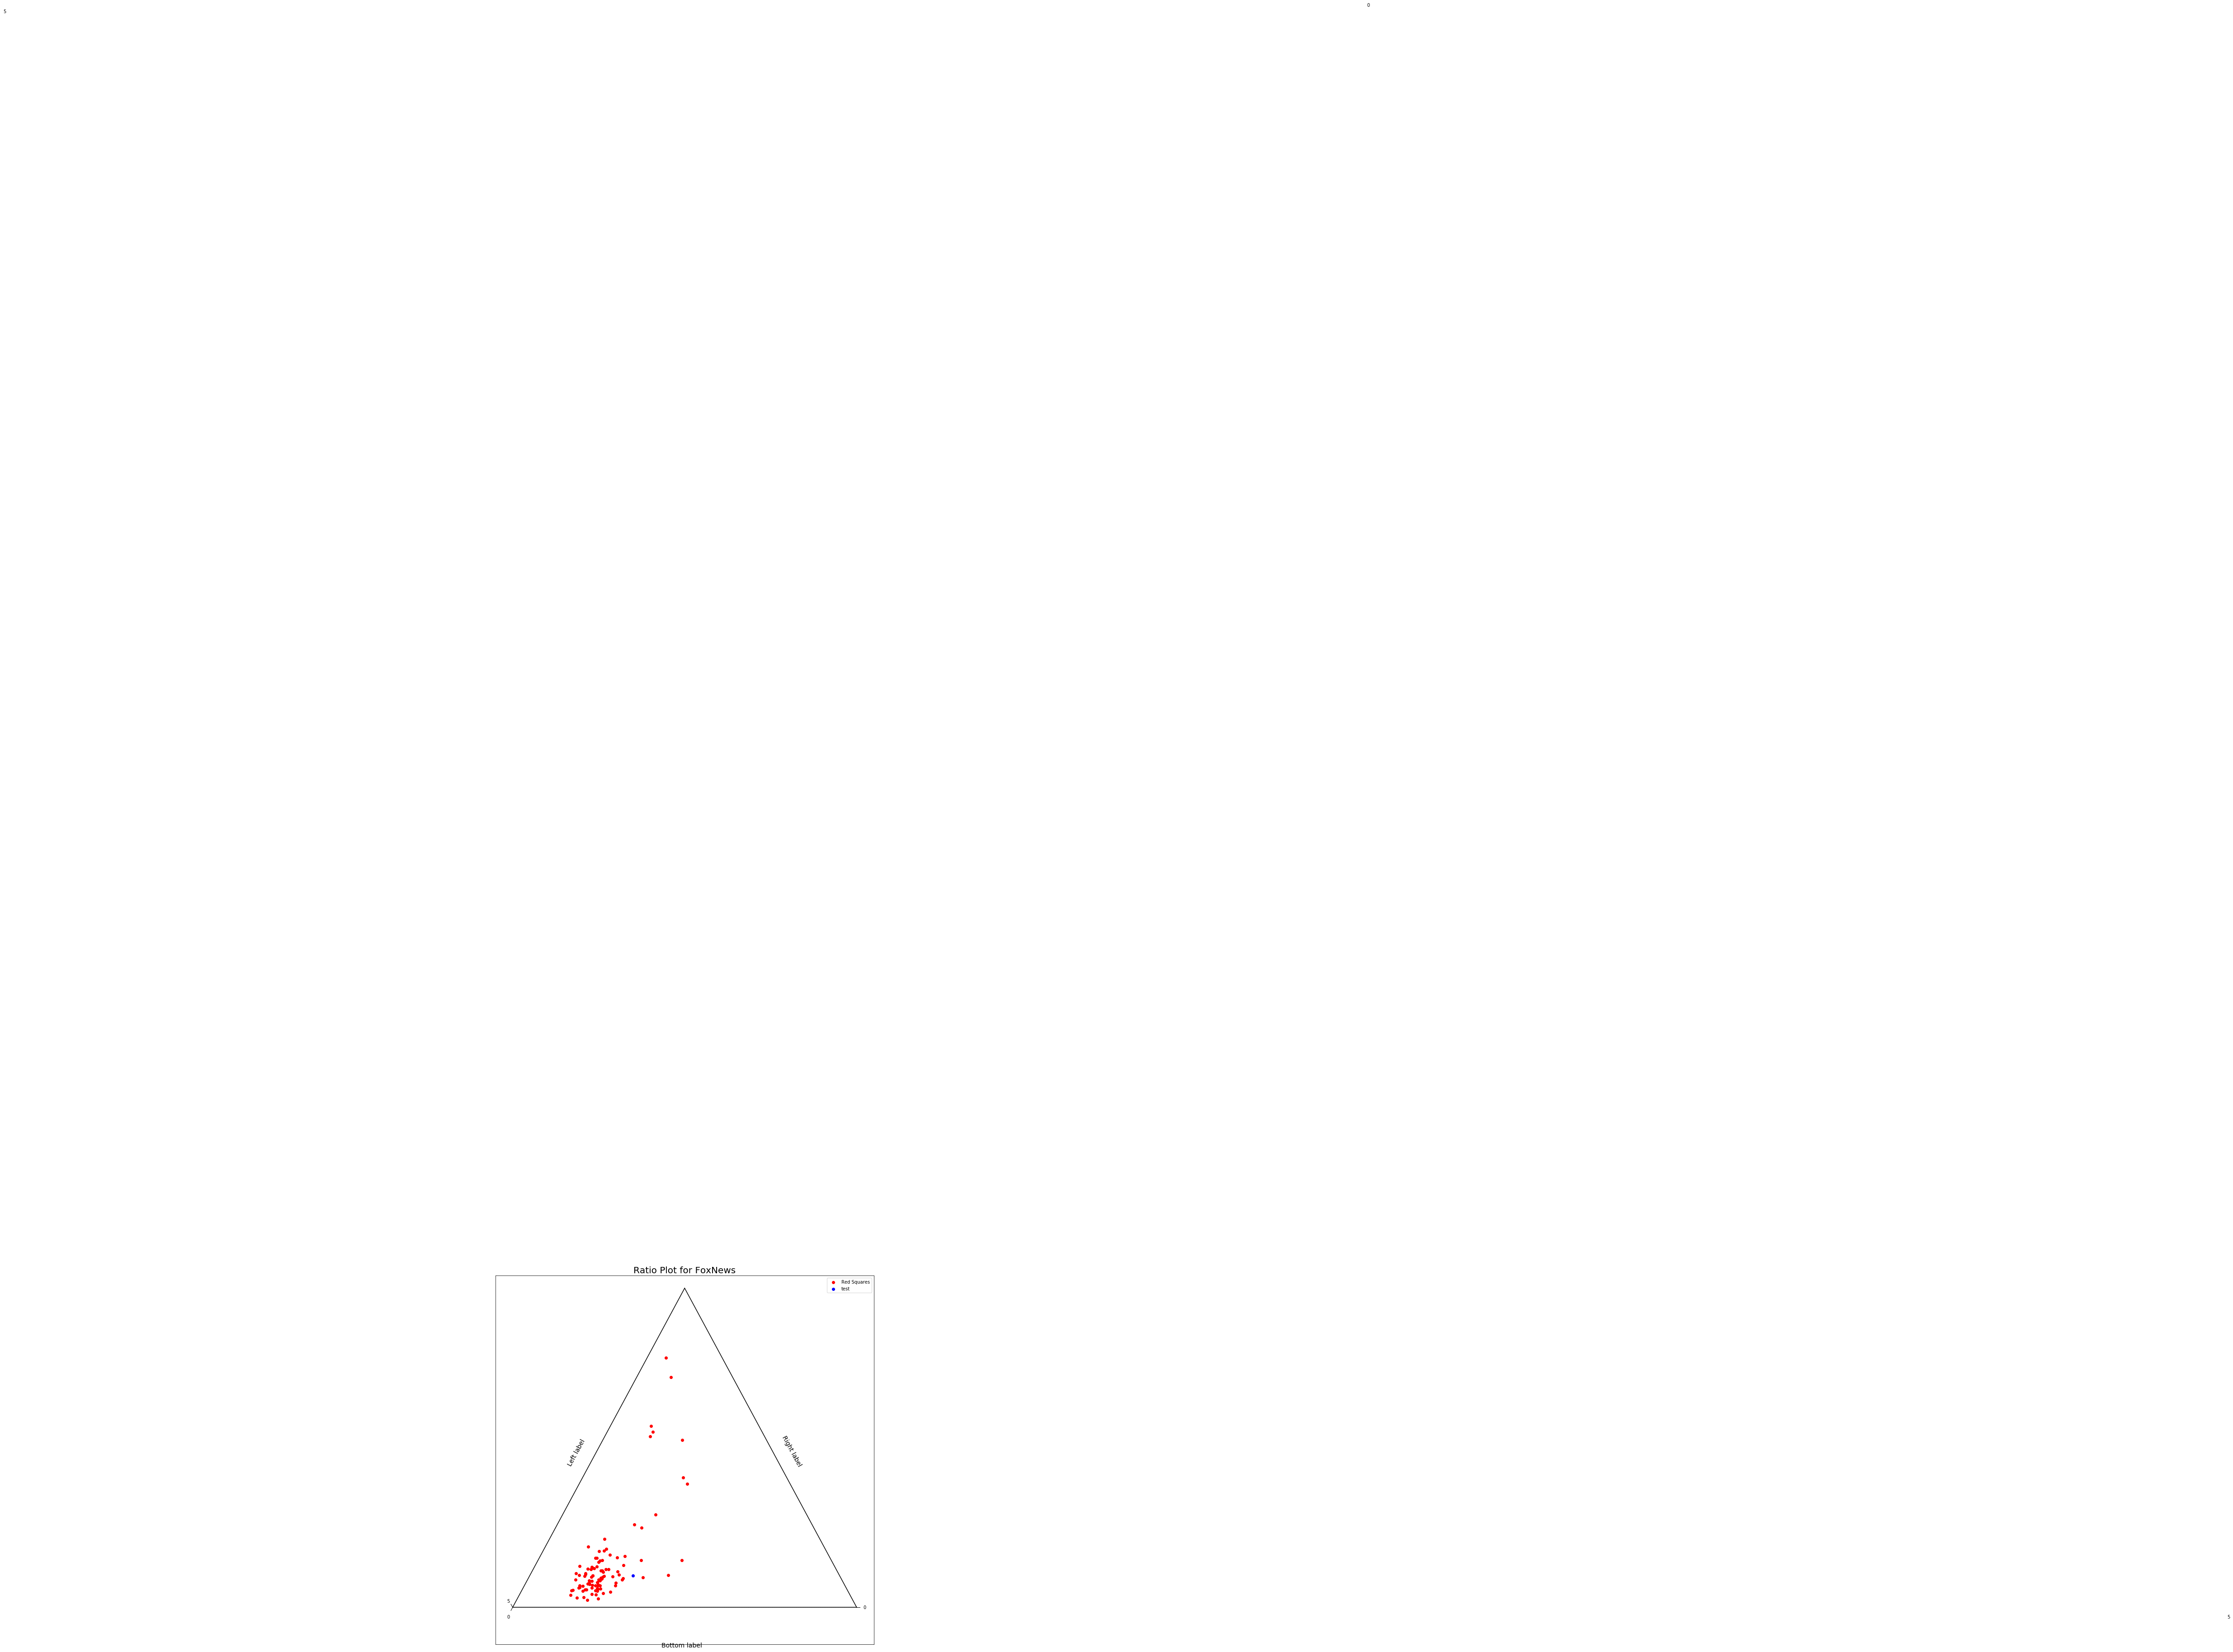

In [349]:
scale = 1

figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(15, 15)
# Set Axis labels and Title
tax.boundary(linewidth=1.5)
tax.gridlines(multiple=5, color="k")
tax.set_title("Ratio Plot for {}".format(screenname), fontsize=20)
tax.left_axis_label("Left label ", fontsize=14)
tax.right_axis_label("Right label ", fontsize=14)
tax.bottom_axis_label("Bottom label ", fontsize=14)

# Plot a few different styles with a legend
points = [i[0] for i in happ_tups]
tax.scatter(points, marker='o', color='red', label="Red Squares")
tax.scatter([(.3,.1,.6)],color='blue',label='test')
tax.legend()
tax.ticks(linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.savefig('taxplot.pdf')
tax.show()

In [23]:
import pickle

In [31]:
file = open('ratiodictTheTweetOfGod.pkl',"rb")
ratiosGod = pickle.load(file)
ratiosGod = pd.DataFrame(ratiosGod).transpose()
ratiosGod
#ratiosGod.to_csv('ratios/{}-ratios.csv'.format('TheTweetOfGod'))



,happ_score,happ_words,likes,replies,retweets,scrape_date,total_words,tweet_date,tweet_id,url
974665705328005121,5.9214,365,11788,150,2730,2018-04-29_17_17_29,1253,2018-03-16,974665705328005121,http://twitter.com/TheTweetOfGod/status/974665...
974713843166269441,6.08265,961,48473,621,10810,2018-04-29_17_16_06,3372,2018-03-16,974713843166269441,http://twitter.com/TheTweetOfGod/status/974713...
974816867553439744,5.71957,951,38801,507,9619,2018-04-29_17_14_40,3176,2018-03-16,974816867553439744,http://twitter.com/TheTweetOfGod/status/974816...
975360001148530688,6.02327,704,29989,647,4745,2018-04-29_17_13_14,2348,2018-03-18,975360001148530688,http://twitter.com/TheTweetOfGod/status/975360...
975499246362226693,5.87378,715,28669,1.2K,4459,2018-04-29_17_11_51,2868,2018-03-18,975499246362226693,http://twitter.com/TheTweetOfGod/status/975499...
975520659311812610,6.11292,706,13785,248,7876,2018-04-29_17_10_27,2672,2014-03-29,975520659311812610,http://twitter.com/TheTweetOfGod/status/975520...
976069293493256192,5.70886,685,25188,671,11057,2018-04-29_17_09_01,2232,2018-03-20,976069293493256192,http://twitter.com/TheTweetOfGod/status/976069...
976146312562327553,6.08077,443,10113,175,2478,2018-04-29_17_07_37,1526,2018-03-20,976146312562327553,http://twitter.com/TheTweetOfGod/status/976146...
976559593261211648,6.11331,668,50321,493,12906,2018-04-29_17_06_15,2288,2018-03-21,976559593261211648,http://twitter.com/TheTweetOfGod/status/976559...
976926745927475200,6.10006,644,26079,499,4374,2018-04-29_17_04_52,2036,2018-03-22,976926745927475200,http://twitter.com/TheTweetOfGod/status/976926...


In [75]:
ls

failedjsons/                      jsons/
finishedjsons/                    kanye-ratio-wordcount.png
geckodriver*                      ratios/
geckodriver-v0.20.1-macos.tar.gz  ratios_w_happ/
geckodriver.log                   screenshots/
getreplies_selenium.py            test_getreplies_selenium.py
getreplies_selenium_whapp.py      tests/
happ_vectors/                     tweet_convos/
happreplies.py


In [38]:
jfile = open('finishedjsons/tweetskanye.json')
jsontweets = []
for line in jfile:
    jsontweets.append(line)
    
failedtweets = ['989554444990738432']

In [40]:
if len(failedtweets) > 0:
    #failedfile = open('failedjsons/{}'.format('finishedjsons/tweetskanye.json'),'a+')
    for tweetid in failedtweets:
        for line in jsontweets:
            if tweetid in line:
                print(line)

{"user":{"screen_name": "kanyewest"},"id": 989554444990738432}



In [26]:
convo = 'tweet_convos-noratio/realDonaldTrump/2018-04-17_14_34-realDonaldTrump-986540431436640256-id-6.4K_15808_66892-tweetconvo-2018-04-28_21_06_18.txt'

In [28]:
import re
re.search('(?<=-tweetconvo-).*(?=.txt)',convo[-115:]).group(0)
re.search('(?<=/).*',convo[-115:]).group(0)[:10]

'2018-04-17'

In [10]:
len(convo)

106